# Falkner Skan Equation with formualtion A


Epoch 0, Loss: [5217.45571573]
Epoch 10000, Loss: [9412.485601]
Epoch 20000, Loss: [8489.60773966]
Epoch 30000, Loss: [8236.49044837]
Epoch 40000, Loss: [8132.15293448]
Epoch 50000, Loss: [8069.76984613]
Epoch 60000, Loss: [8023.7040843]
Epoch 70000, Loss: [7986.69079621]
Epoch 80000, Loss: [7955.96808278]
Epoch 90000, Loss: [7930.0402237]


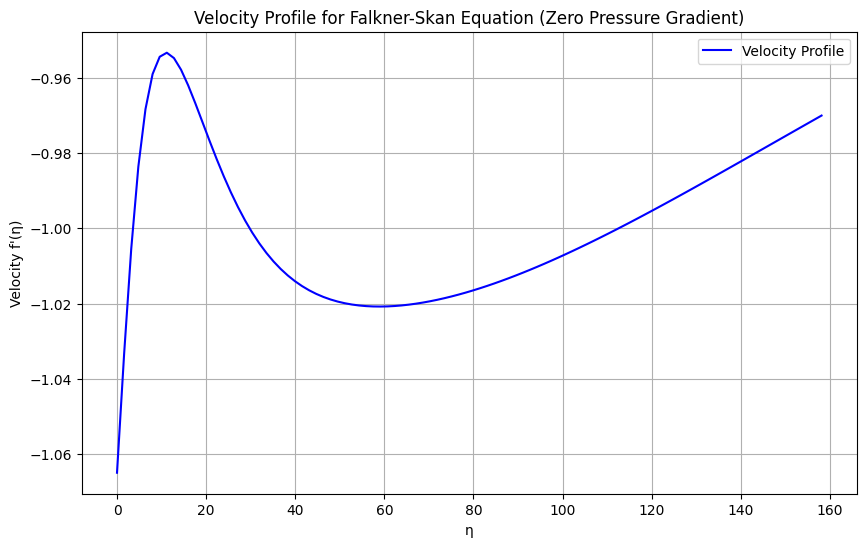

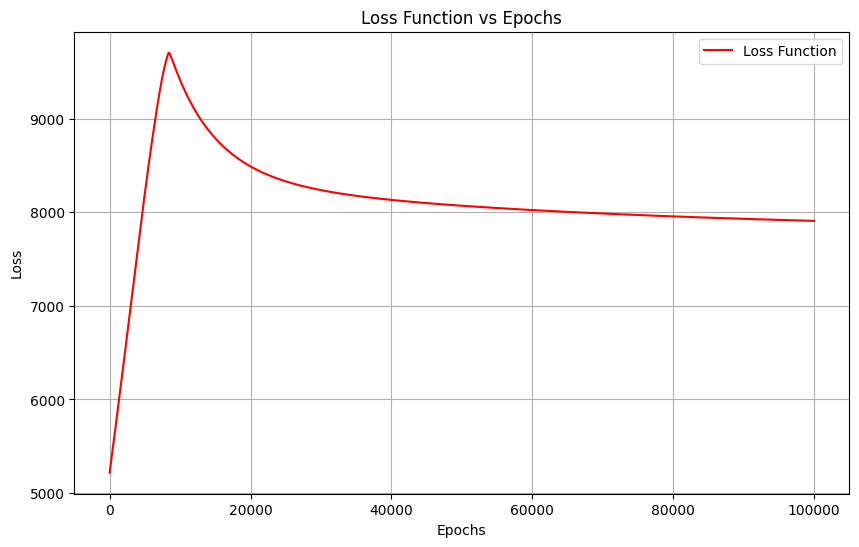

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid activation function with clipping for numerical stability
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clipping to prevent overflow

# Derivative of the sigmoid function for backpropagation
def sigmoid_derivative(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

# eta transformation function
def eta(x_data, y_data, m, k, neu):
    return y_data * (((m + 1) / 2) * (k / neu)) ** 0.5 * x_data ** ((m - 1) / 2)

# Define the Falkner-Skan equation with the composite loss function
def loss_function(f_prime, f_double_prime, f_triple_prime, f, m):
    beta = 2 * m / (m + 1)  # Calculate beta for the Falkner-Skan equation

    # Falkner-Skan equation residual with third derivative
    residual = f_triple_prime + f_prime * f_double_prime + beta * (1 - f_prime**2)

    # Boundary conditions
    bc1 = f_prime[0]  # f'(0) = 0 (no velocity at the wall)
    bc2 = f_prime[99] - 1  # f'(infinity) = 1 (far from boundary layer, flow reaches freestream velocity)
    bc3 = f[0]  # f(0) = 0 (no displacement at the wall)

    # Composite loss: residuals + boundary conditions
    return np.mean(residual**2) + 1000 * (bc1**2 + bc2**2 + bc3**2)

def train_pielm(eta_data, m, k, neu, n_neurons, learning_rate, epochs):
    # Improved weight initialization using Xavier initialization
    W_input = np.random.randn(eta_data.shape[1], n_neurons) * np.sqrt(2 / (eta_data.shape[1] + n_neurons))
    b_input = np.zeros((1, n_neurons))  # Bias for hidden layer
    W_output = np.random.randn(n_neurons, 1) * np.sqrt(2 / (n_neurons + 1))
    b_output = np.zeros((1, 1))  # Bias for output layer
    
    # Training loop
    loss_history = []
    
    for epoch in range(epochs):
        # Forward pass: Compute hidden layer outputs and velocity profile
        H = sigmoid(np.dot(eta_data, W_input) + b_input)  # Hidden layer activations
        f_prime = np.dot(H, W_output) + b_output  # Velocity profile f'(η)
        f = np.cumsum(f_prime.flatten()) * (eta_data[1] - eta_data[0])  # Integrate to get f(η)

        # Compute f''(η) and f'''(η) (numerical derivatives)
        f_double_prime = np.gradient(f_prime.flatten(), eta_data.flatten())
        f_triple_prime = np.gradient(f_double_prime, eta_data.flatten())

        # Calculate the loss (residuals + boundary conditions)
        current_loss = loss_function(f_prime, f_double_prime, f_triple_prime, f, m)

        # Backpropagation: Compute the gradients for W_input, b_input, W_output, and b_output
        residual_term = f_prime.flatten() * f_double_prime + (2 * m / (m + 1)) * (1 - f_prime.flatten()**2) + f_triple_prime
        
        # Gradient for W_output and b_output
        dW_output = np.dot(H.T, residual_term.reshape(-1, 1))
        db_output = np.sum(residual_term)  # Gradient for the output bias
        
        # For W_input and b_input, backpropagate the residual through the hidden layer
        dW_input = np.dot(eta_data.T, (np.dot(residual_term.reshape(-1, 1), W_output.T) * sigmoid_derivative(H)))
        db_input = np.sum(np.dot(residual_term.reshape(-1, 1), W_output.T) * sigmoid_derivative(H), axis=0)

        dW_input /= eta_data.shape[0]  # Normalize by the number of samples
        
        # Update weights and biases using gradient descent with clipping
        W_input -= learning_rate * np.clip(dW_input, -1, 1)
        b_input -= learning_rate * np.clip(db_input, -1, 1)
        W_output -= learning_rate * np.clip(dW_output, -1, 1)
        b_output -= learning_rate * np.clip(db_output, -1, 1)

        # Store the loss for plotting later
        loss_history.append(current_loss)

        # Print the loss every 100 epochs
        if epoch % 10000 == 0:
            print(f'Epoch {epoch}, Loss: {current_loss}')

    return W_input, b_input, W_output, b_output, loss_history

# Predict the velocity profile using the trained PIELM
def predict_velocity(eta_data, W_input, b_input, W_output, b_output):
    H = sigmoid(np.dot(eta_data, W_input) + b_input)  # Hidden layer activations
    velocity_profile = np.dot(H, W_output) + b_output  # Predicted velocity f'(η)
    return velocity_profile

# Define the domain and set up the parameters
x_data = np.linspace(0, 5, 100).reshape(-1, 1)  # Collocation points from 0 to 5
y_data = np.linspace(0, 5, 100).reshape(-1, 1)  # Similarity variable in y-direction
k = 0.1  # Some constant
neu = 0.0001  # Dynamic viscosity
m = 0  # Zero pressure gradient (flat plate)
n_neurons = 100  # Number of neurons in the hidden layer
learning_rate = 0.000001  # Reduced learning rate for stability
epochs = 100000  # Number of epochs
eta_data = eta(x_data, y_data, m, k, neu)

# Train the PIELM
W_input, b_input, W_output, b_output, loss_history = train_pielm(eta_data, m, k, neu, n_neurons, learning_rate, epochs)

# Predict the velocity profile using the trained weights
velocity_profile = predict_velocity(eta_data, W_input, b_input, W_output, b_output)

# Plot the velocity profile with respect to η
plt.figure(figsize=(10, 6))
plt.plot(eta_data, velocity_profile, label='Velocity Profile', color='blue')
plt.title('Velocity Profile for Falkner-Skan Equation (Zero Pressure Gradient)')
plt.xlabel('η')
plt.ylabel('Velocity f\'(η)')
plt.legend()
plt.grid()
plt.show()

# Plot the loss function vs epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), loss_history, label='Loss Function', color='red')
plt.title('Loss Function vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


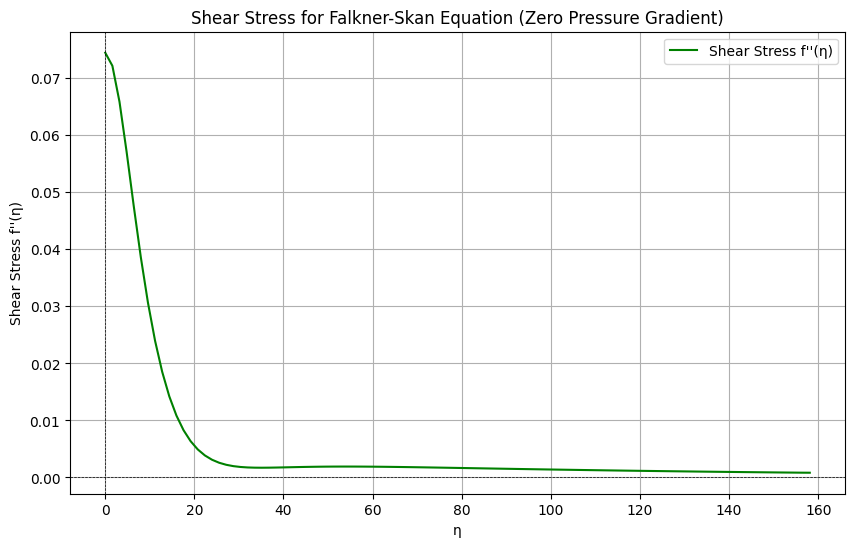

In [62]:
# Calculate the second derivative f''(η) using the numerical derivative of f'(η)
f_double_prime = np.gradient(velocity_profile.flatten(), eta_data.flatten())

# Plot the shear stress f''(η) with respect to η
plt.figure(figsize=(10, 6))
plt.plot(eta_data, f_double_prime, label='Shear Stress f\'\'(η)', color='green')
plt.title('Shear Stress for Falkner-Skan Equation (Zero Pressure Gradient)')
plt.xlabel('η')
plt.ylabel('Shear Stress f\'\'(η)')
plt.axhline(0, color='black', lw=0.5, linestyle='--')  # Add a horizontal line at y=0
plt.axvline(0, color='black', lw=0.5, linestyle='--')  # Add a vertical line at x=0
plt.legend()
plt.grid()
plt.show()


In [63]:
# Calculate Displacement Thickness (δ*)
displacement_thickness = np.trapz(1 - velocity_profile.flatten(), eta_data.flatten())

# Calculate Momentum Thickness (θ)
momentum_thickness = np.trapz(velocity_profile.flatten() * (1 - velocity_profile.flatten()), eta_data.flatten())

# Calculate Shape Factor (H)
shape_factor = displacement_thickness / momentum_thickness 

# Print the results
print(f'Displacement Thickness (δ*): {displacement_thickness:.4f}')
print(f'Momentum Thickness (θ): {momentum_thickness:.4f}')
print(f'Shape Factor (H): {shape_factor:.4f}')


Displacement Thickness (δ*): 186.6765
Momentum Thickness (θ): -37.0477
Shape Factor (H): -5.0388
